In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import MonthLocator, DateFormatter
import seaborn as sns
from statsmodels.graphics import tsaplots 
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm

import glob
import os

%matplotlib inline

# Import and combine data

In [2]:
# List of data files in folder ../data/raw/
!ls ../data/raw/

TsaThroughput.ANC.csv   TsaThroughput.FLL.csv   TsaThroughput.PHX.csv
TsaThroughput.ATL.csv   TsaThroughput.LAS.csv   TsaThroughput.SEA.csv
TsaThroughput.All.csv   TsaThroughput.LAX.csv   TsaThroughput.SFO.csv
TsaThroughput.BOI.csv   TsaThroughput.MCO.csv   TsaThroughput.SJC.csv
TsaThroughput.BZN.csv   TsaThroughput.MIA.csv   TsaThroughput.TPA.csv
TsaThroughput.DEN.csv   TsaThroughput.MSO.csv   TsaThroughput.Total.csv
TsaThroughput.DFW.csv   TsaThroughput.PDX.csv


In [3]:
def multiple_csv_to_dict(path):
    
    '''Reads multiple csv files from a given path
    and combines into a single dictionary'''
    
    files = glob.glob(path)

    data = []
    names = []

    for file in files:
        df = pd.read_csv(file)
        data.append(df)
        names.append(file.split('.')[-2])
    
    return dict(zip(names, data))

In [4]:
# Create a dictionary with airport acronyms as keys and content of csv files as values
airport_dict = multiple_csv_to_dict('../data/raw/*.*.csv')
airport_dict.keys()

dict_keys(['DFW', 'SEA', 'Total', 'DEN', 'SFO', 'LAX', 'BOI', 'BZN', 'MSO', 'TPA', 'MIA', 'PHX', 'LAS', 'PDX', 'FLL', 'MCO', 'All', 'ANC', 'ATL', 'SJC'])

In [5]:
# Want to keep individual airport data; pop out 'Total' and 'All' 
airport_dict.pop('Total')
airport_dict.pop('All')
airport_dict.keys()

dict_keys(['DFW', 'SEA', 'DEN', 'SFO', 'LAX', 'BOI', 'BZN', 'MSO', 'TPA', 'MIA', 'PHX', 'LAS', 'PDX', 'FLL', 'MCO', 'ANC', 'ATL', 'SJC'])

In [6]:
def make_individual_dfs(df, name):
    
    '''For each airport, create dataframe, set index to datetime, 
    sum over values for all gates and drop unnecessary columns'''

    # Set index to datetime
    df.index = pd.to_datetime(df['Date'] + ' ' + df['Hour'])
    df = df.drop(columns=['Date', 'Hour'])
    
    # Sum across values from each gate to get total for a given date and time (up to the hour)
    df = pd.DataFrame(df.sum(axis=1))
    df.rename(columns={0:name}, inplace=True)
    
    return df

In [7]:
def join_airports(list_names):
    
    '''Combines resulting dataframes into a single dataframe'''
    
    airports=[]
    
    for name in list_names: 
        airports.append(make_individual_dfs(airport_dict.get(name), name))
        airport_df = pd.concat(airports, axis=1)
    
    return airport_df

In [8]:
# Created a sorted list of airport names
airport_names = [name for name in airport_dict.keys()]
airport_names.sort()

In [9]:
# Dataframe of TSA throughput for all airports (all gates)
df = join_airports(airport_names)
df.tail()

,ANC,ATL,BOI,BZN,DEN,DFW,FLL,LAS,LAX,MCO,MIA,MSO,PDX,PHX,SEA,SFO,SJC,TPA
2022-02-05 19:00:00,24.0,1692.0,9.0,NaN,617.0,1120.0,1491.0,853.0,1792.0,2330.0,3057.0,NaN,146.0,1257.0,580.0,773.0,80.0,387.0
2022-02-05 20:00:00,34.0,1458.0,18.0,NaN,613.0,895.0,920.0,983.0,1881.0,861.0,2336.0,NaN,48.0,593.0,619.0,893.0,53.0,119.0
2022-02-05 21:00:00,159.0,1054.0,NaN,NaN,373.0,357.0,483.0,1340.0,2145.0,470.0,983.0,NaN,66.0,498.0,581.0,1035.0,11.0,94.0
2022-02-05 22:00:00,253.0,179.0,NaN,NaN,401.0,154.0,145.0,1677.0,1181.0,213.0,267.0,NaN,153.0,602.0,306.0,680.0,20.0,NaN
2022-02-05 23:00:00,165.0,236.0,NaN,NaN,494.0,34.0,28.0,683.0,470.0,11.0,149.0,NaN,38.0,341.0,157.0,215.0,2.0,NaN


* ANC - Anchorage
* ATL - Atlanta
* BOI - Boise
* BZN - Bozeman
* DEN - Denver
* DFW - Dallas Fort Worth
* FLL - Fort Lauderdale
* LAS - Las Vegas
* LAX - Los Angeles
* MCO - Orlando
* MIA - Miami
* MSO - Missoula Montana
* PDX - Portland
* PHX - Phoenix
* SEA - Seattle
* SFO - San Francisco
* SJC - San Jose
* TPA - Tampa

# Explore data

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 27216 entries, 2018-12-30 00:00:00 to 2022-02-05 23:00:00
Freq: H
Data columns (total 18 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ANC     26985 non-null  float64
 1   ATL     26513 non-null  float64
 2   BOI     19626 non-null  float64
 3   BZN     17779 non-null  float64
 4   DEN     27186 non-null  float64
 5   DFW     24839 non-null  float64
 6   FLL     23792 non-null  float64
 7   LAS     27215 non-null  float64
 8   LAX     25785 non-null  float64
 9   MCO     24941 non-null  float64
 10  MIA     27211 non-null  float64
 11  MSO     16701 non-null  float64
 12  PDX     27206 non-null  float64
 13  PHX     27215 non-null  float64
 14  SEA     27214 non-null  float64
 15  SFO     25581 non-null  float64
 16  SJC     20325 non-null  float64
 17  TPA     21527 non-null  float64
dtypes: float64(18)
memory usage: 3.9 MB


In [11]:
# Shape of dataframe
df.shape

(27216, 18)

In [12]:
# Summary statistics
df.describe().T

,count,mean,std,min,25%,50%,75%,max
ANC,26985.0,210.573967,154.729967,0.0,95.0,180.0,287.0,1094.0
ATL,26513.0,2148.751198,1829.063290,0.0,267.0,1912.0,3609.0,8202.0
BOI,19626.0,270.544966,199.508061,0.0,104.0,245.0,397.0,1292.0
BZN,17779.0,139.272962,128.619313,0.0,43.0,103.0,196.0,830.0
DEN,27186.0,1949.017527,1586.510462,0.0,393.0,1758.0,3328.0,6642.0
DFW,24839.0,1994.838661,1540.055232,0.0,440.0,1888.0,3265.0,6770.0
FLL,23792.0,1784.690232,1197.076639,0.0,653.0,1883.0,2743.0,5507.0
LAS,27215.0,1948.071835,1508.062165,0.0,466.5,1816.0,3158.0,6385.0
LAX,25785.0,3097.091061,2323.019113,0.0,992.0,2751.0,4928.0,10250.0
MCO,24941.0,2273.608476,1717.449356,0.0,441.0,2304.0,3848.0,6973.0


In [13]:
# Are there any duplicates?
df.duplicated().any()

False

## Visualize Data Distribution

### Histograms

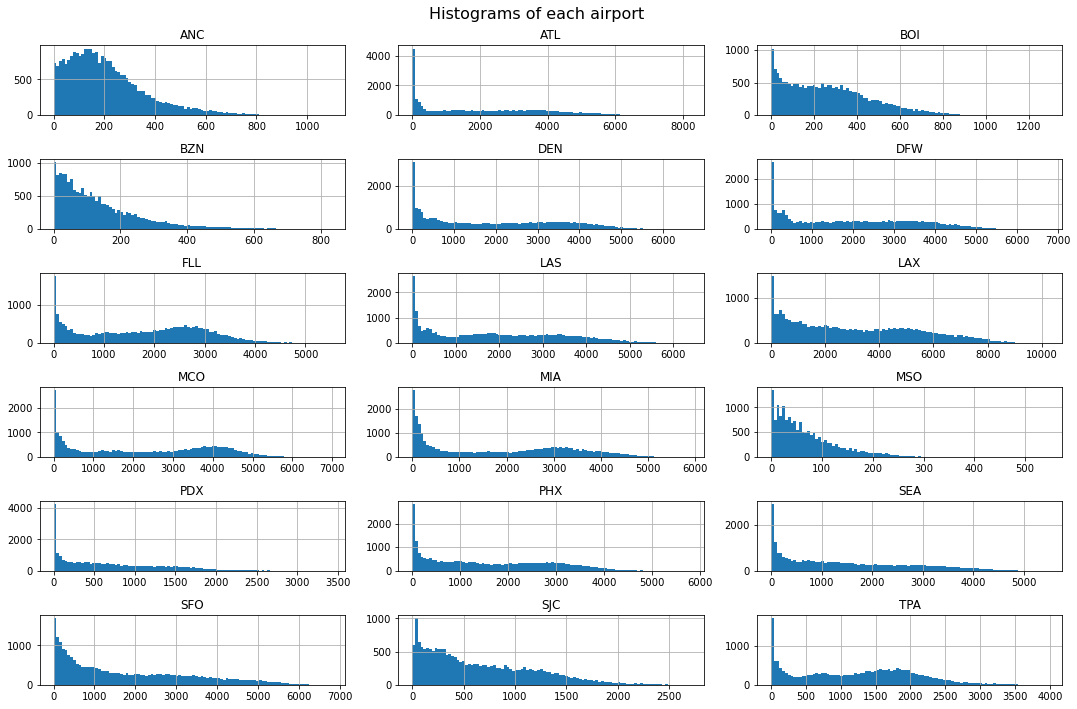

In [14]:
# Histograms of each airport 
df.hist(figsize=(15,10), layout=(6,3), bins=100)
plt.suptitle('Histograms of each airport', fontsize=16)
plt.tight_layout();

In [73]:
def plot_airport_hist(airport, small=100, large=1000, bins=500, sbins=20, mbins=200, lbins=500):
    
    '''Plot multiple histograms for an airport for different numbers
    of passengers going through TSA checkpoints. Left-top plot is of 
    all values. Top right is for small number of people. Bottom right 
    represents very large number of people going through, while bottom 
    left plot is of mid-level counts.'''
    
    fig, ax = plt.subplots(2,2, figsize=(15,8))
    plt.subplots_adjust(hspace=0.1)
    fig.suptitle(airport, fontsize=18, y=0.95)
    
    # Plot histogram of all values
    ax[0,0].hist(df[airport], bins=bins, label='Original')
    
    # Plot histogram of small counts
    ax[0,1].hist(df[airport][df[airport]<=small], bins=sbins, label='Small')
    
    # Plot histogram of medium counts
    ax[1,0].hist(df[airport][(df[airport]>small) & (df[airport]<=large)], bins=mbins, label='Mid-values')
    
    # Plot histogram of large counts
    ax[1,1].hist(df[airport][df[airport]>large], bins=lbins, label='Large')
    
    for axs in ax.flat:
        axs.set(xlabel='Number of people', ylabel='Counts')
        axs.legend()

    plt.show()

**Let's look at histograms of a few individual airports more closely**

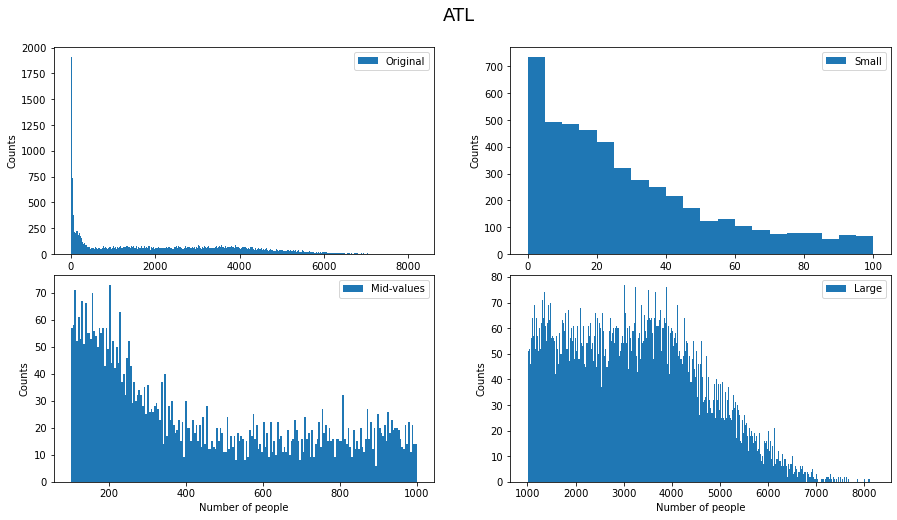

In [86]:
# Atlanta International Airport (ATL)
# Using default small, mid and large values of 100, 100-1,000, and more than 1,000

plot_airport_hist('ATL')

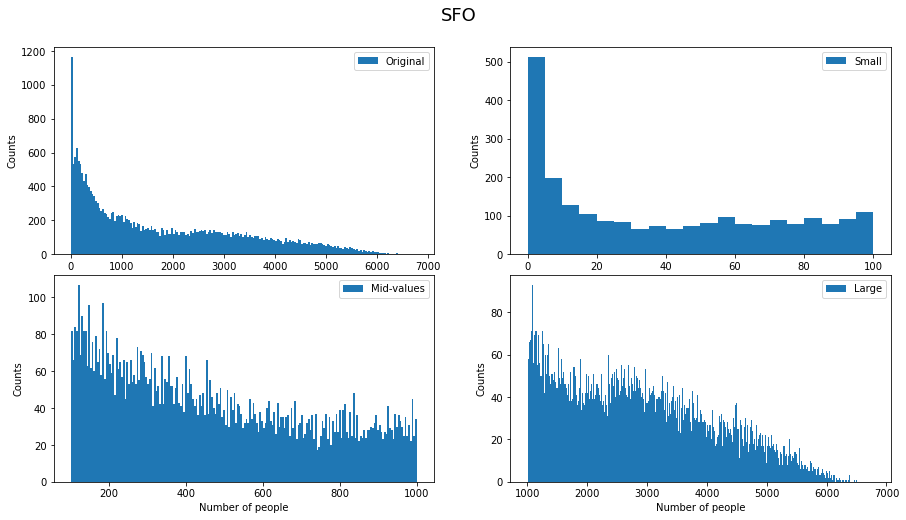

In [75]:
# San Francisco International Airport (SFO)
# Using default small, mid and large values of 100, 100-1,000, and more than 1,000

plot_airport_hist('SFO', bins=200)

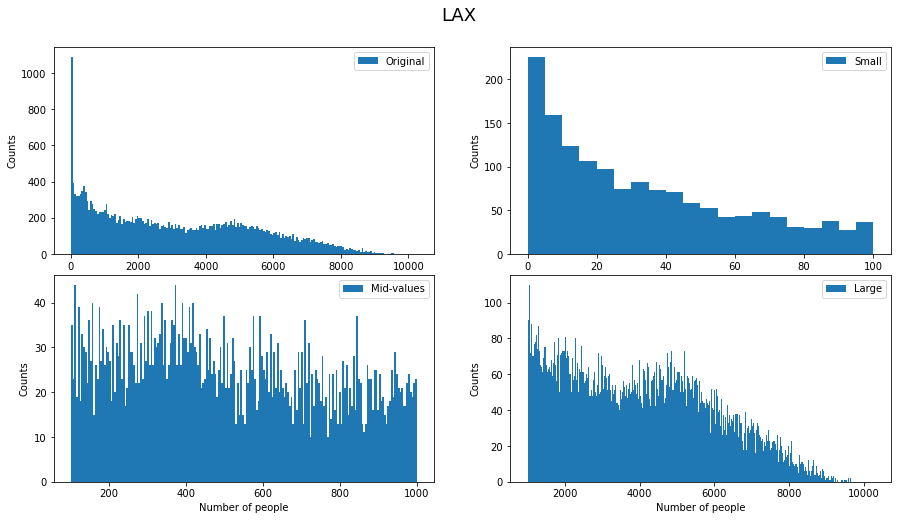

In [76]:
# Los Angeles International Airport (LAX)
# Using default small, mid and large values of 100, 100-1,000, and more than 1,000

plot_airport_hist('LAX', bins=200)

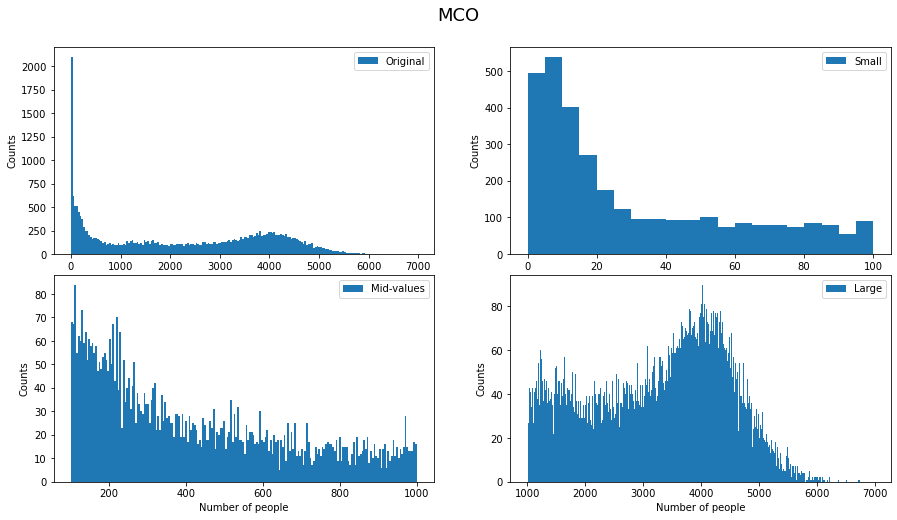

In [77]:
# Orlando International Airport (MCO) 
# Using default small, mid and large values of 100, 100-1,000, and more than 1,000

plot_airport_hist('MCO', bins=200)

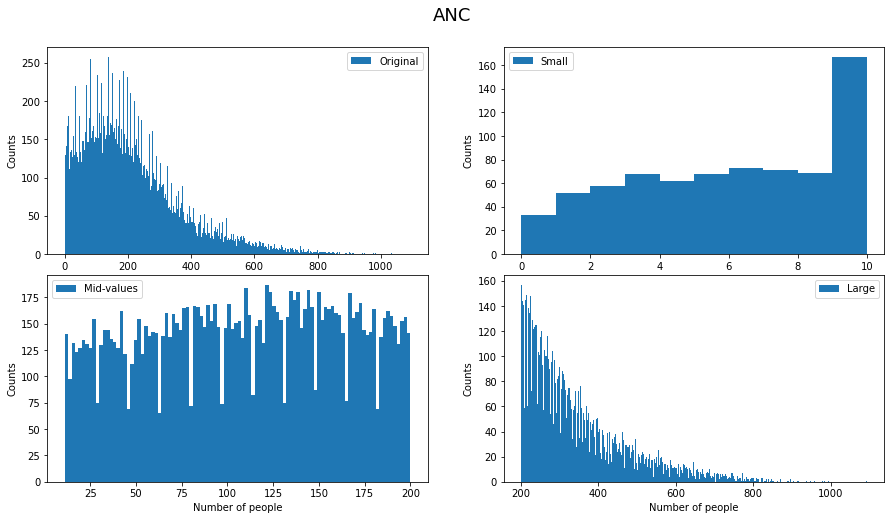

In [78]:
# Anchorage International Airport (ANC) 
# Using small < 10, mid between 10 and 200 and large > 200

plot_airport_hist('ANC', small=10, large=200, sbins=10, mbins=100)

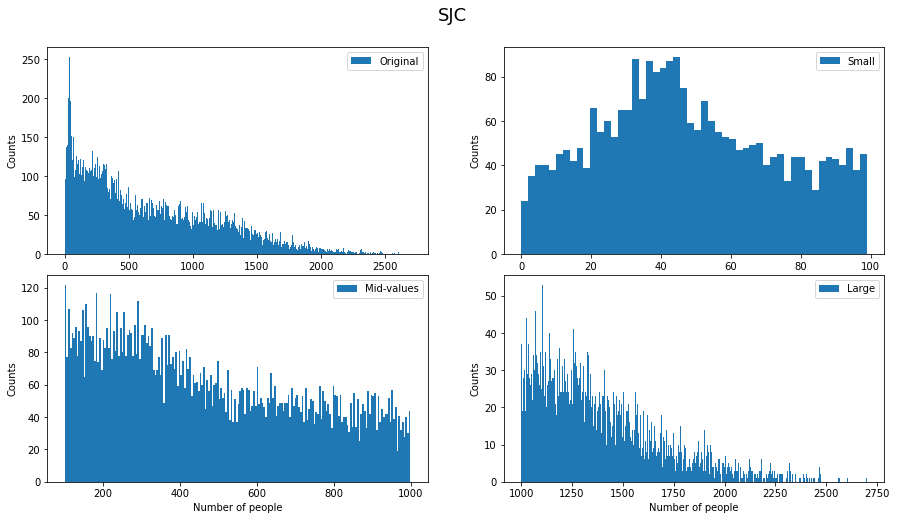

In [21]:
# San Jose International Airport (SJC) 
# Using default small, mid and large values of 100, 100-1,000, and more than 1,000

plot_airport_hist('SJC', sbins=50)

Distributions for nearly all airports are quite high for lower throughput counts and for most airports, values decrease as number of people going through for a give time period increases (quite rapidly). The large airports  have a second peak where a higher numbers of people are going through TSA for a given hourly time period.

### Boxplots

In [22]:
# Sorted index by median value in descending order
sorted_index = df.median().sort_values(ascending=False).index
sorted_index

Index(['LAX', 'MCO', 'ATL', 'DFW', 'FLL', 'LAS', 'DEN', 'MIA', 'PHX', 'SFO',
       'TPA', 'SEA', 'PDX', 'SJC', 'BOI', 'ANC', 'BZN', 'MSO'],
      dtype='object')

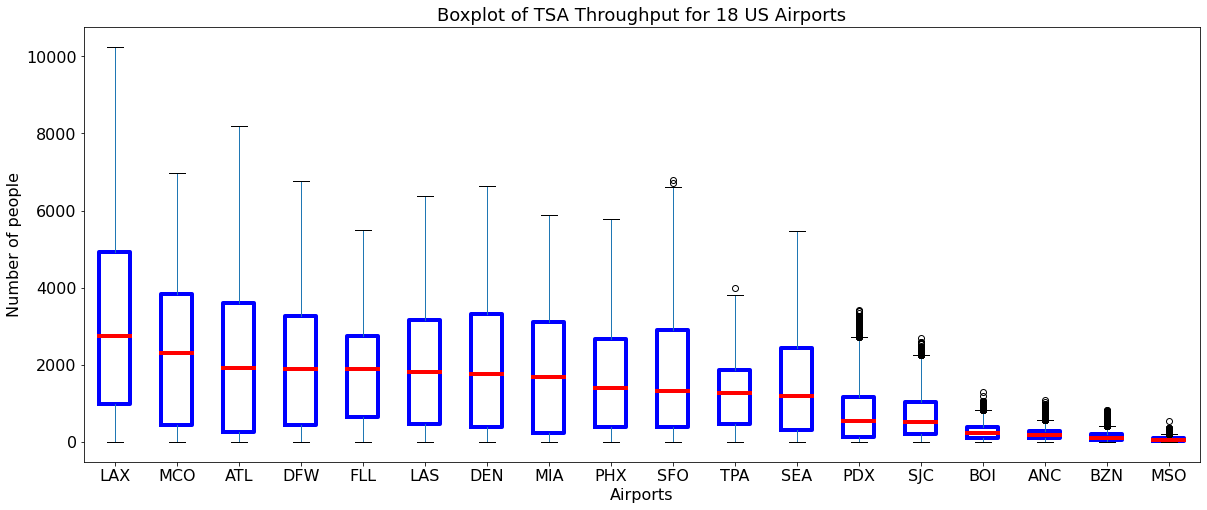

In [23]:
# Boxplot of airport data sorted by median in descending order
boxprops = dict(linestyle='-', linewidth=4, color='b')
medianprops = dict(linestyle='-', linewidth=4, color='r')
df[sorted_index].boxplot(figsize=(20,8),grid=False, boxprops=boxprops, medianprops=medianprops, fontsize=16)
plt.xlabel('Airports', fontsize=16)
plt.ylabel('Number of people',fontsize=16)
plt.title('Boxplot of TSA Throughput for 18 US Airports',fontsize=18);

From the boxplots, it is easy to identify small vs large airports. LAX gets the highest throughput while Boise International, Anchorage, Bozeman International and Missoula Montana airports are the smallest airports on the list. 

### Density plots

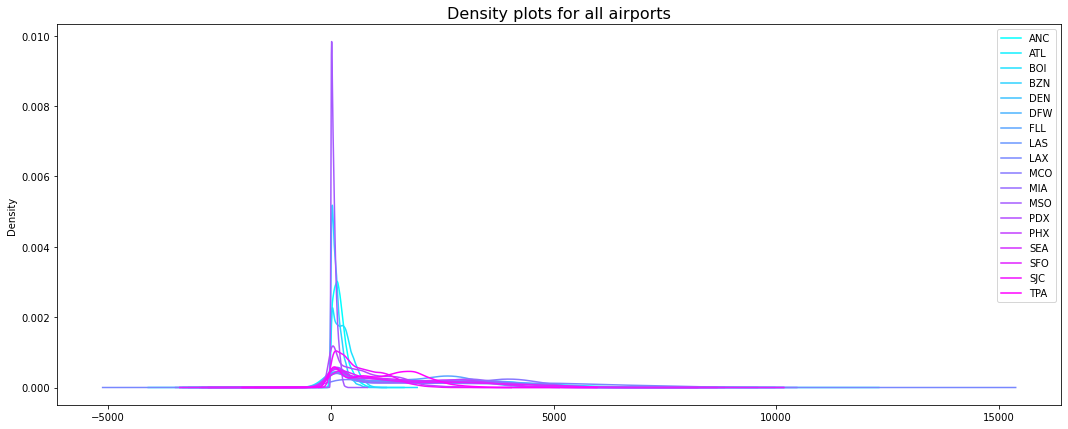

In [24]:
# Density plots for all airports
df.plot(kind='density', figsize=(18,7), colormap='cool')
plt.title('Density plots for all airports', fontsize=16);

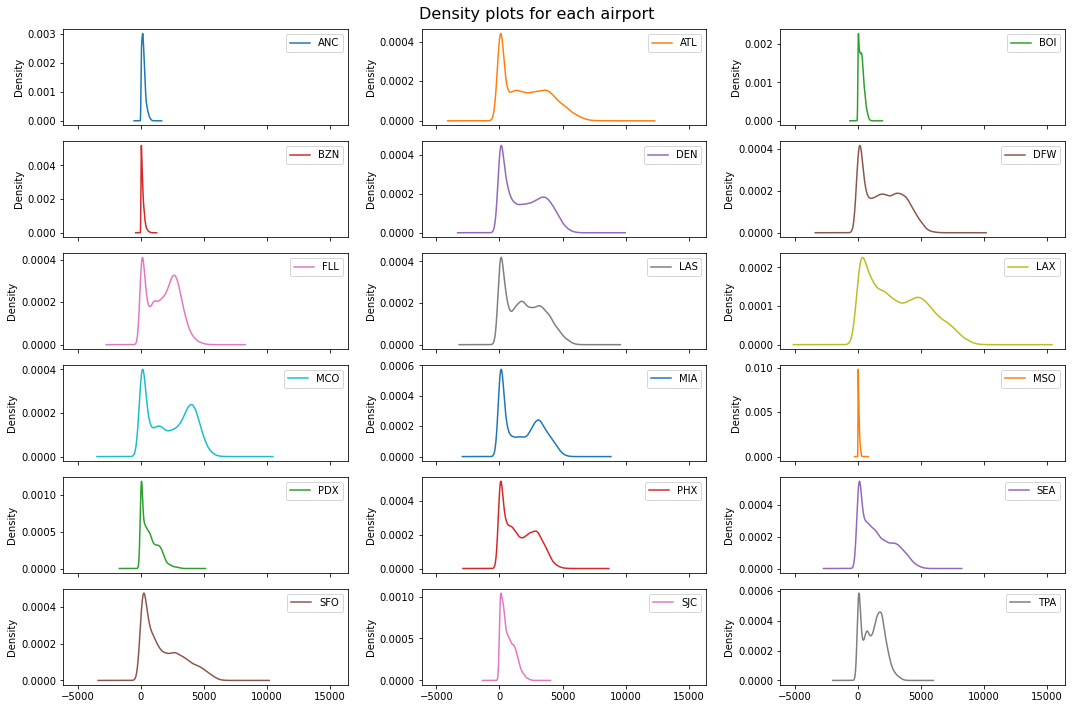

In [25]:
# Density plots with different y scales
df.plot(kind='density', figsize=(15,10), layout=(6,3), subplots=True, sharex=True)
plt.suptitle('Density plots for each airport', fontsize=16)
plt.tight_layout();

From the density plots, we can better see the second peak appearing for larger throughput values as airports become larger. 

## Timeseries plots

In [26]:
def plot_timeseries(series, figsize=(20,8), cmap=None, alpha=1, subplots=True, layout=(1,1), sharex=False, sharey=False,
                    ylabel='TSA Throughput', xlabel='Datetime', hspace= 0.5, legend=True,suptitle='TSA Throughput Timeseries'):
    
    '''Timeseires plots'''
    
    series.plot(figsize=figsize, cmap=cmap, alpha=alpha, subplots=subplots, layout=layout,
                    sharex=sharex, sharey=sharey, ylabel=ylabel, xlabel=xlabel, legend=legend)
    plt.subplots_adjust(hspace=hspace)
    plt.suptitle(suptitle)
    plt.tight_layout()
    plt.show()

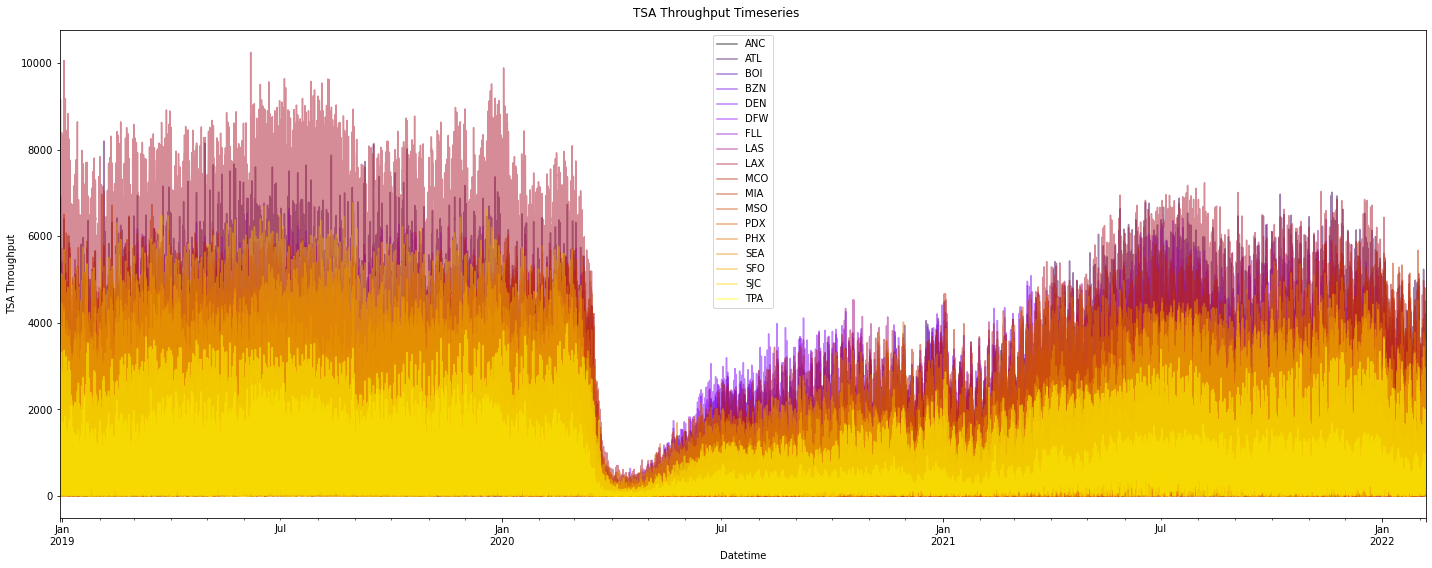

In [27]:
# Timeseries plot for all airports
plot_timeseries(df, cmap='gnuplot', alpha=0.5, subplots=False)

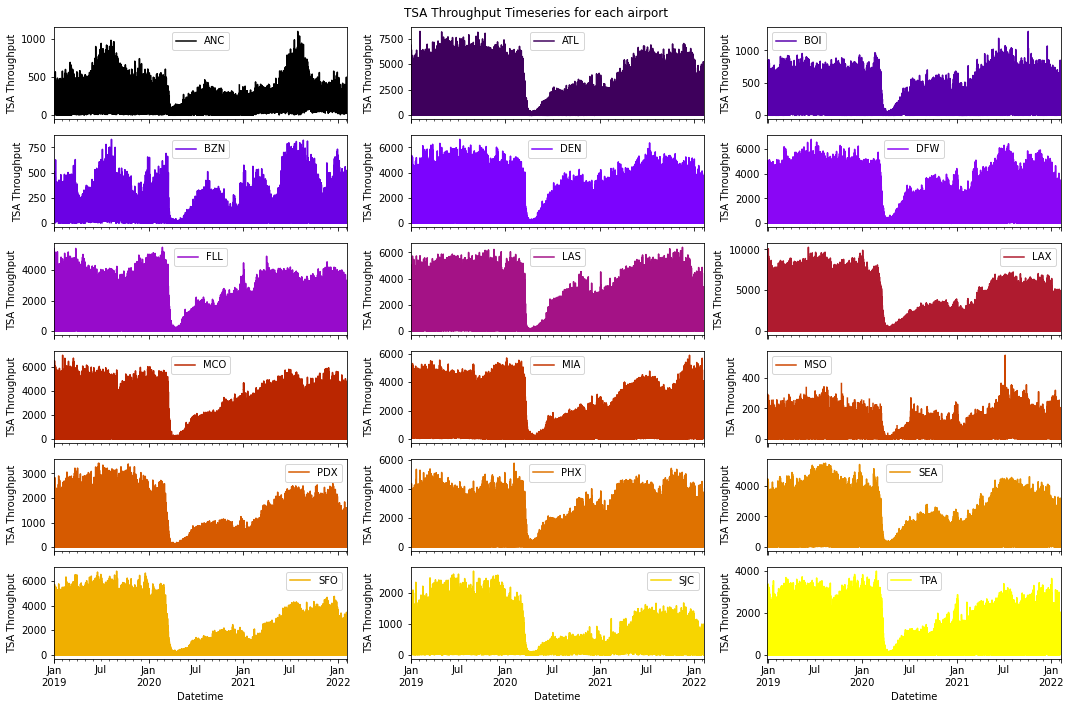

In [28]:
# Timeseries plot for all airports (not on same y scale)
plot_timeseries(df, figsize=(15,10), cmap='gnuplot', layout=(6,3), subplots=True, sharex=True, 
                suptitle='TSA Throughput Timeseries for each airport')

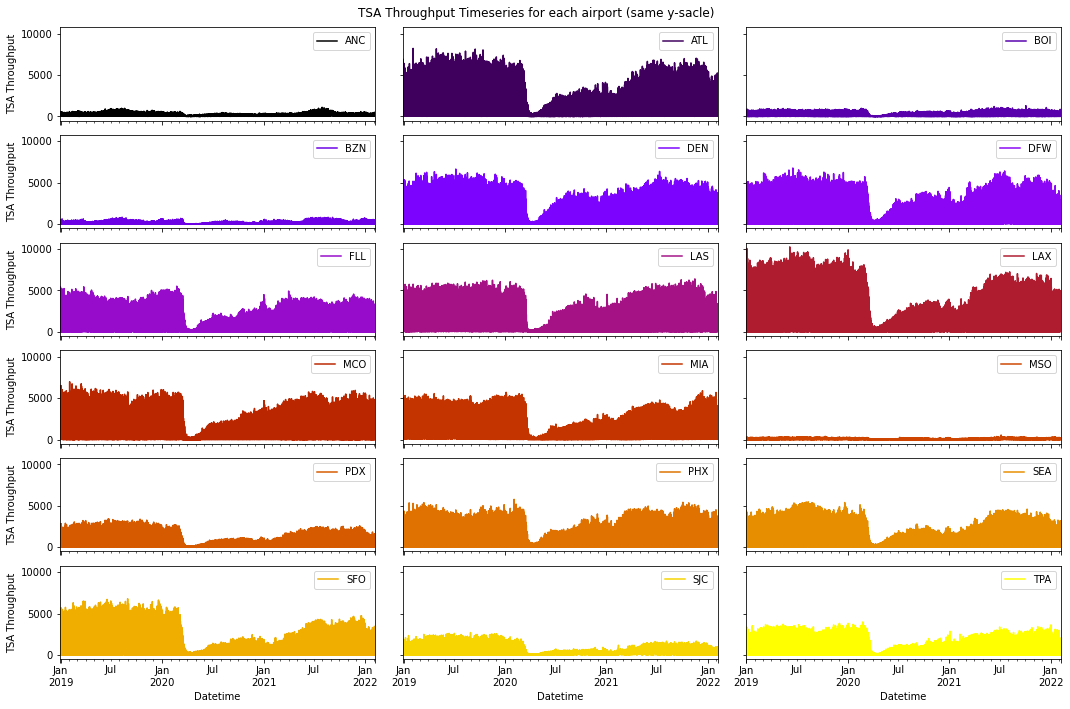

In [29]:
# Timeseries plots for each airports using same scale for the y-axis 
plot_timeseries(df, figsize=(15,10), cmap='gnuplot', layout=(6,3), subplots=True, sharex=True, sharey=True,
                suptitle='TSA Throughput Timeseries for each airport (same y-sacle)')

## Treatment of NA values

In [30]:
# How many null values?
null_values = pd.DataFrame(df.isna().sum().sort_values(ascending=False), columns=['count'])
null_values['percent'] = round(df.isna().mean()*100, 2)
null_values

,count,percent
MSO,10515,38.64
BZN,9437,34.67
BOI,7590,27.89
SJC,6891,25.32
TPA,5689,20.90
FLL,3424,12.58
DFW,2377,8.73
MCO,2275,8.36
SFO,1635,6.01
LAX,1431,5.26


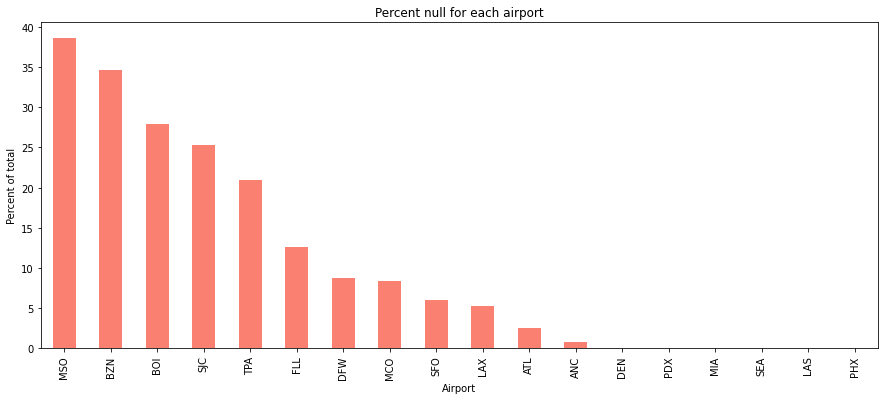

In [31]:
# Bar plot of percent null for each airport
null_values['percent'].plot(kind='bar', figsize=(15,6), color='Salmon')
plt.xlabel('Airport')
plt.ylabel('Percent of total')
plt.title('Percent null for each airport');

The small airports such as MSO, BZN, BOI, SJC and TPA have relatively high number of NA values (more than 20 percent). 

In [32]:
def barplots(df):
    '''Barplots of hours with NA values'''
    
    fig, axs = plt.subplots(6, 3, figsize=(15, 12), sharex=True)
    plt.subplots_adjust(hspace=0.5)
    fig.suptitle('Null value distribution per hour for each airport', fontsize=18, y=1)

    for column, ax in zip(df.columns, axs.ravel()):
        df[df[column].isna()].index.hour.value_counts().plot(kind='bar', ax=ax, color='Salmon')
        ax.set_title(column)
        ax.set(xlabel='Hour', ylabel='Null Counts')
        
    plt.tight_layout()
    plt.show()

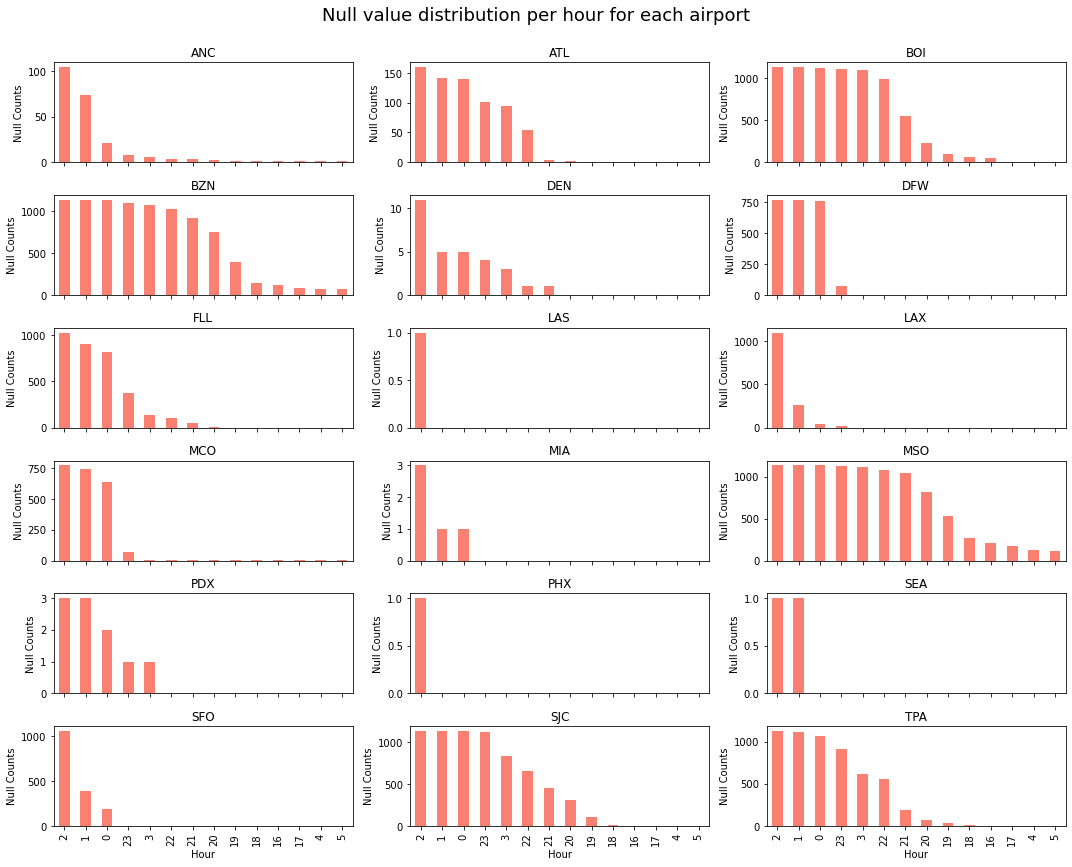

In [150]:
# Plot NA values for each airport
barplots(df)

The small airports (ANC, BOI, BZN, MSO, SJC, and TPA) have a larger time range where they are missing values. Phoenix and LAS only have one missing value. Generally, it appears that all the missing values are in the middle of the night where airports are quite and not as many flights goint out and this range is much wider for smaller airports when fewer outgoing flights would be scheduled in the evening and early morning hours (between 7 pm to 4 am). 

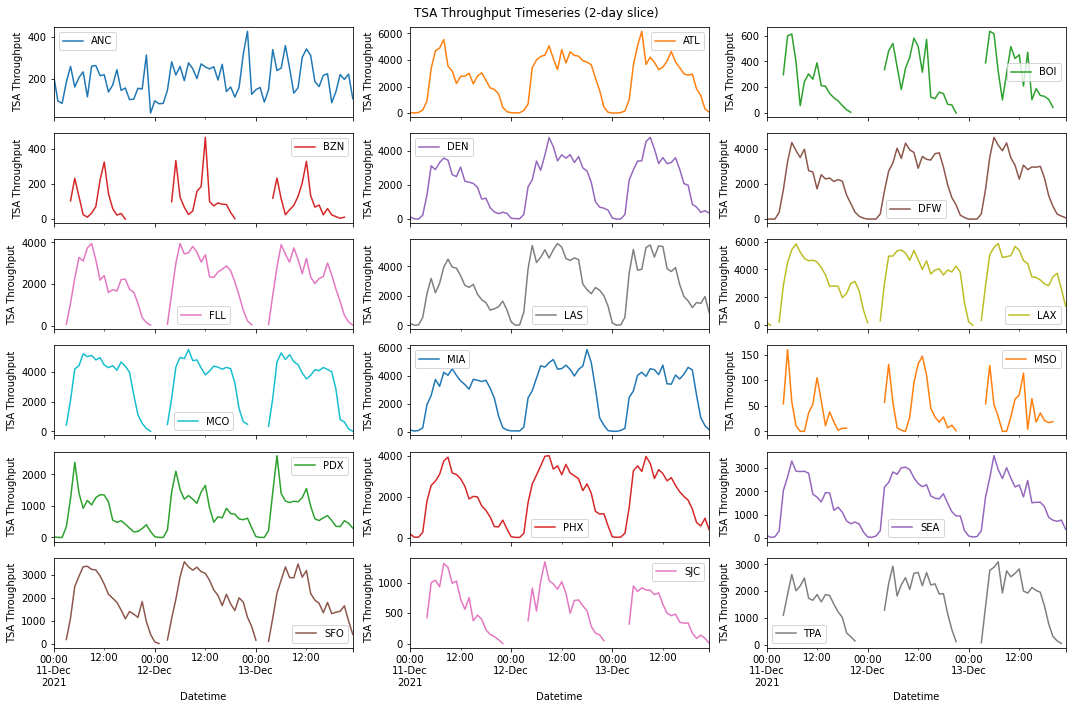

In [34]:
# Visual representation of null values for a time slice for each airport
plot_timeseries(df['2021-12-11':'2021-12-13'], figsize=(15,10), layout=(6,3), sharex=True,
                    suptitle='TSA Throughput Timeseries (2-day slice)')

The zoomed in time series above allow us to visualize our missing values better and we can further verify that missingness occurs in the evening and early morning hours and from experience in small airports such as those in Montana (BZN and MCO) as well as researching flight departures, we can gather that fewer to no outbound flights occur around midnight until 4 am and thus it is most likely that no one passed through TSA checkpoints for those times where values are missing. I shall then fill in the missing values with zero and visualize the data again.

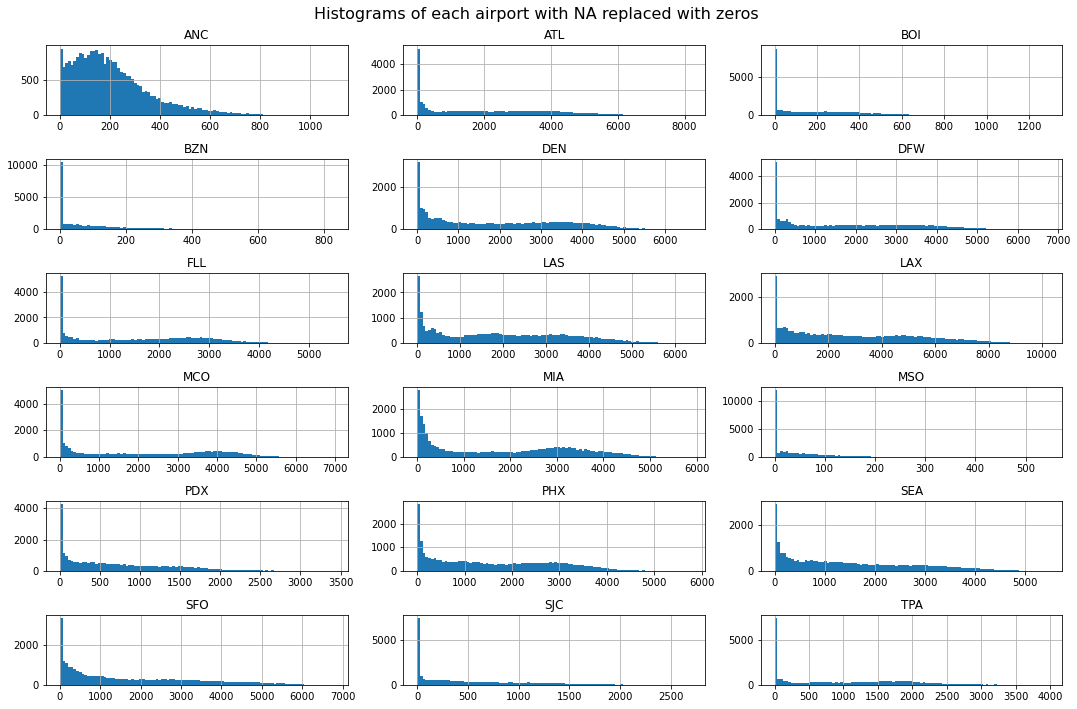

In [35]:
# Histograms of each airport with all NA as zero
df_nona = df.fillna(0)
df_nona.hist(figsize=(15,10), layout=(6,3), bins=100)
plt.suptitle('Histograms of each airport with NA replaced with zeros', fontsize=16)
plt.tight_layout();

In [36]:
# Sort by median value in descending order after imputing NA values with zero
sorted_index_nona = df_nona.median().sort_values(ascending=False).index
sorted_index_nona

Index(['LAX', 'MCO', 'ATL', 'LAS', 'DEN', 'MIA', 'DFW', 'FLL', 'PHX', 'SEA',
       'SFO', 'TPA', 'PDX', 'SJC', 'ANC', 'BOI', 'BZN', 'MSO'],
      dtype='object')

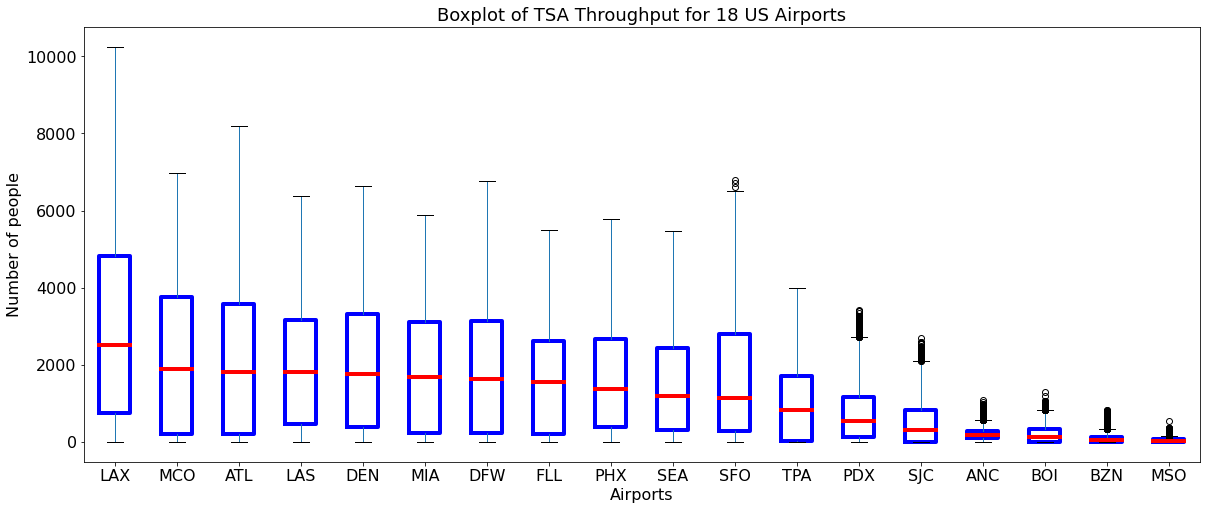

In [37]:
# Boxplot of airport data sorted by median in descending order after imputing NA values with zero
boxprops = dict(linestyle='-', linewidth=4, color='b')
medianprops = dict(linestyle='-', linewidth=4, color='r')
df_nona[sorted_index_nona].boxplot(figsize=(20,8),grid=False, boxprops=boxprops, medianprops=medianprops, fontsize=16)
plt.xlabel('Airports', fontsize=16)
plt.ylabel('Number of people',fontsize=16)
plt.title('Boxplot of TSA Throughput for 18 US Airports',fontsize=18);

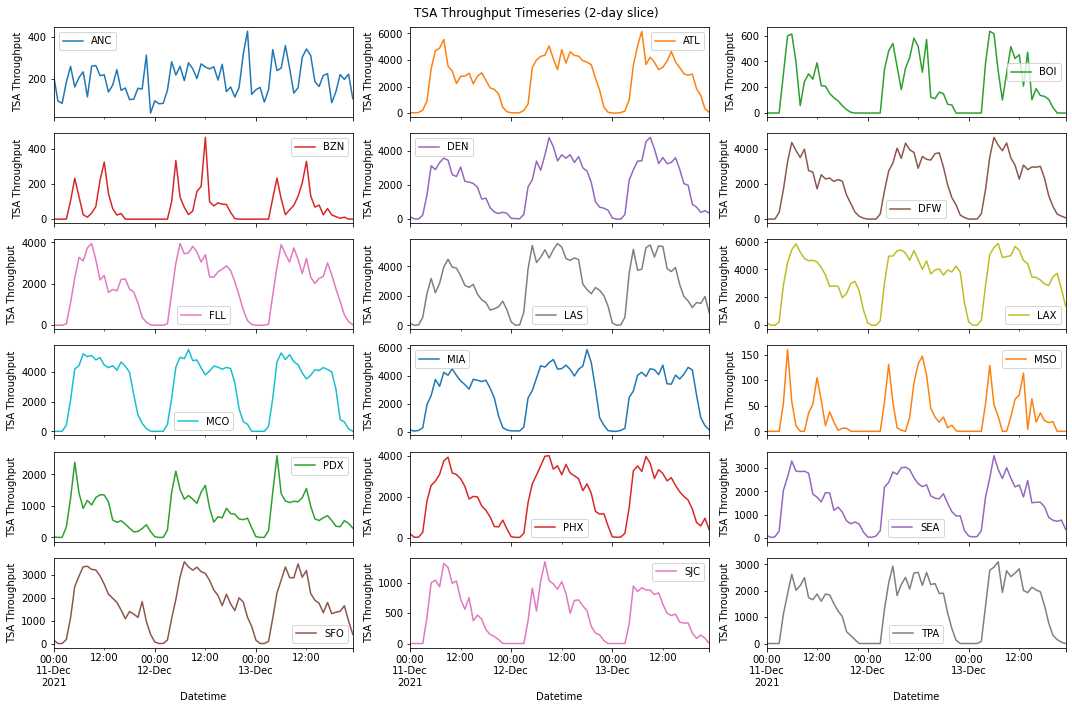

In [38]:
# Visual representation of airport time series after imputing NA values with zero 
plot_timeseries(df_nona['2021-12-11':'2021-12-13'], figsize=(15,10), layout=(6,3), sharex=True,
                    suptitle='TSA Throughput Timeseries (2-day slice)')

## Timeseires slices

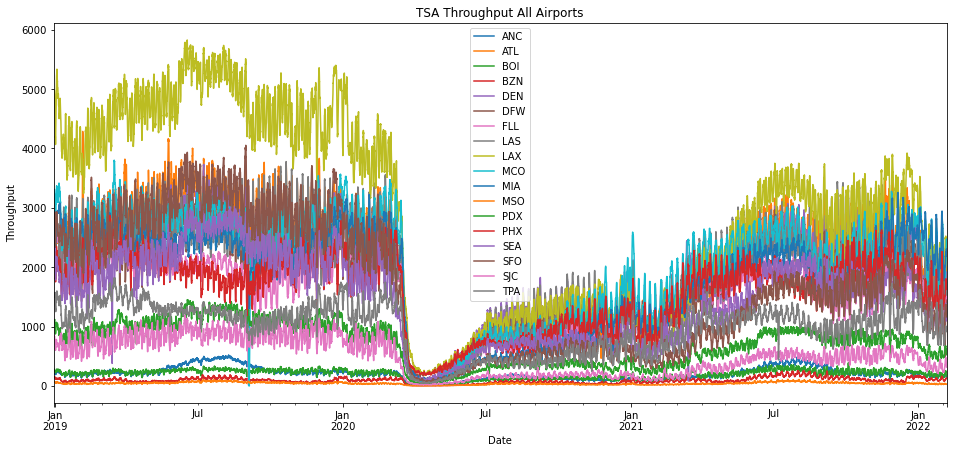

In [399]:
# All airports' rolling average for one full day (24 periods)
df_nona.rolling(24).mean().plot(figsize=(16,7), xlabel='Date', ylabel='Throughput', title='TSA Throughput All Airports');

### Compare trends

In [400]:
def overlap_timeseries(time_slice1, time_slice2, time_slice3, color1, color2, color3, 
                       label1, label2, label3, xlabel='Month of year', ylabel='Throughput', title='Time series'):
    
    '''Plot slices of a given time series overlapped to comopare trends'''
    
    fig, ax = plt.subplots(figsize=(14,6))
    ax.plot(time_slice1, color=color1, label=label1)

    ax2 = ax.twiny()
    ax2.plot(time_slice2, color=color2, label=label2)
    ax2.set_xticks([])
    ax3 = ax.twiny()
    ax3.plot(time_slice3, color=color3, label=label3)
    ax3.set_xticks([])
    
    date_form = DateFormatter("%m")
    ax.xaxis.set_major_formatter(date_form)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    plt.title(title)
    
    plt.show()

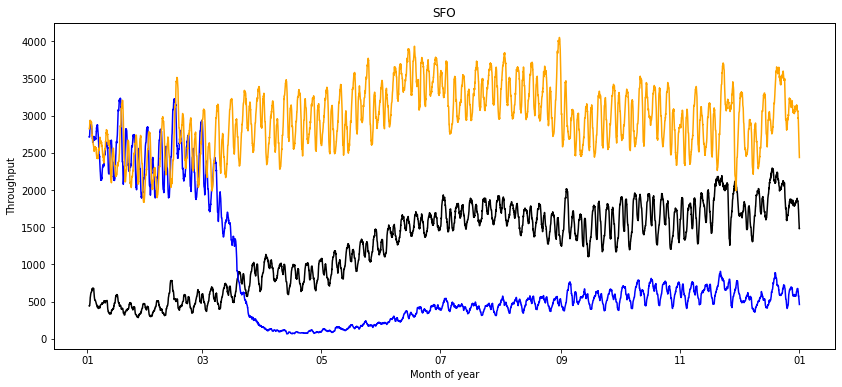

In [401]:
# Compare yearly rolling averages for SFO (window-size=24) 
overlap_timeseries(df_nona.SFO.loc['2021'].rolling(24).mean(), 
                   df_nona.SFO.loc['2020'].rolling(24).mean(), 
                   df_nona.SFO.loc['2019'].rolling(24).mean(),
                   'black', 'blue','orange', '2021', '2020', '2019', title='SFO')

In [392]:
def yearly_trend(dataframe, date1, date2, date3, color1, color2, color3, 
                       xlabel='Month of year', ylabel='Throughput'):
    
    '''Plot overlapped trends of different time slices for each airport'''
    
    fig, axs = plt.subplots(6, 3, figsize=(15, 12), sharex=True)
    plt.subplots_adjust(hspace=0.5)
    fig.suptitle('Yearly Trends', fontsize=18, y=1)

    for column, ax in zip(dataframe.columns, axs.ravel()):
        line1, = ax.plot(dataframe[column].loc[date1].rolling(168).mean(), color=color1, label=date1)
        ax2 = ax.twiny()
        line2, = ax2.plot(dataframe[column].loc[date2].rolling(168).mean(), color=color2, label=date2)
        ax2.set_xticks([])
        ax3 = ax.twiny()
        line3, = ax3.plot(dataframe[column].loc[date3].rolling(168).mean(), color=color3, label=date3)
        ax3.set_xticks([])
        
        date_form = DateFormatter("%m")
        ax.xaxis.set_major_formatter(date_form)
        ax.set_xlabel('Month of year')
        ax.set_ylabel('Throughput')
        plt.title(column)
                
    plt.tight_layout()

    plt.show()

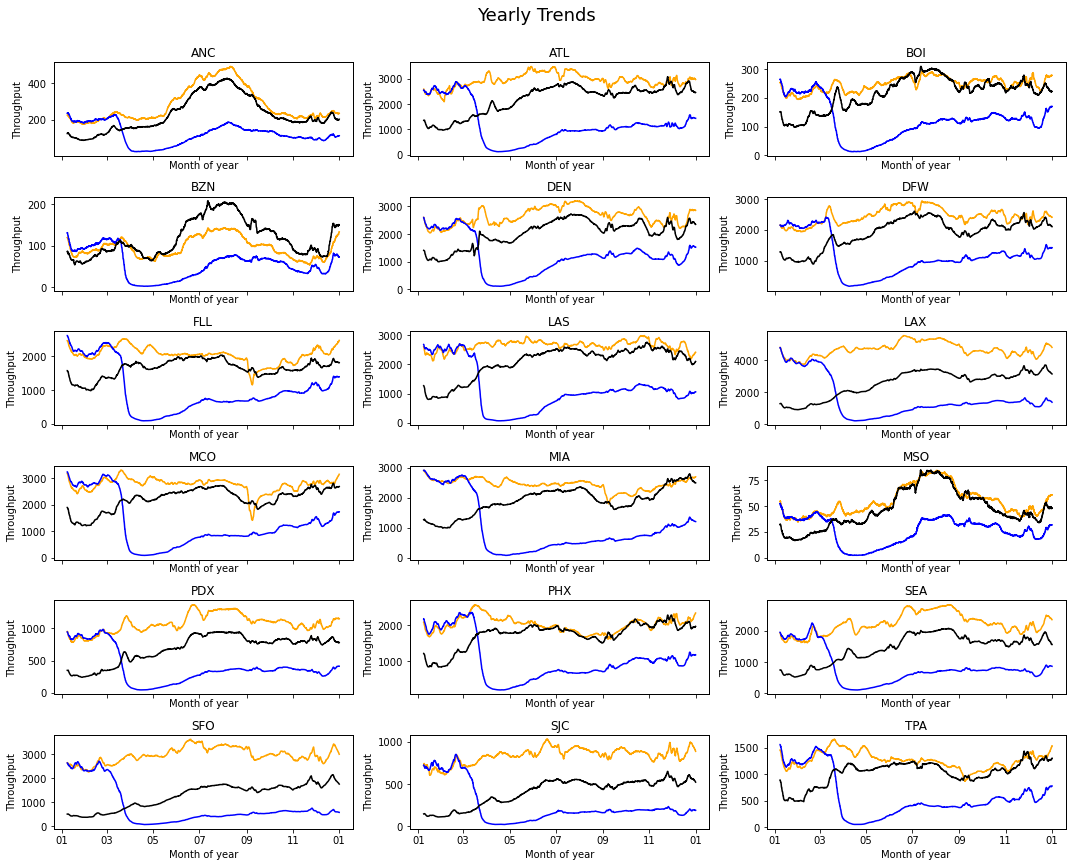

In [393]:
# Caompare yearly trends for each airport for 2019, 2020 and 2021
yearly_trend(df_nona, '2019', '2020', '2021', 'orange', 'blue', 'black')

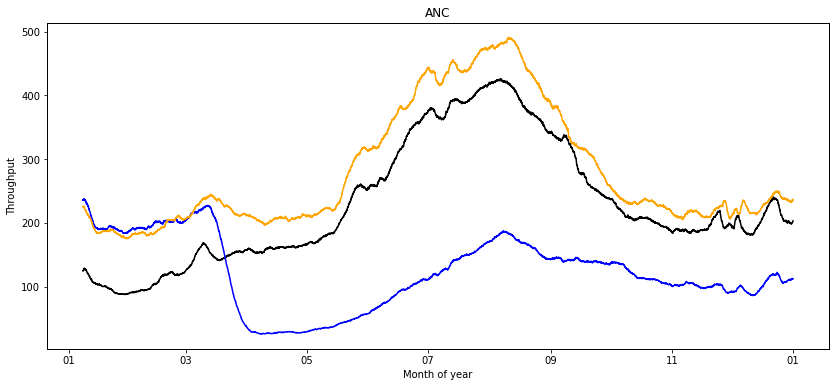

In [394]:
# Compare yearly rolling averages for ANC (window-size=168) 
overlap_timeseries(df_nona.ANC.loc['2021'].rolling(168).mean(), 
                   df_nona.ANC.loc['2020'].rolling(168).mean(), 
                   df_nona.ANC.loc['2019'].rolling(168).mean(),
                   'black', 'blue','orange', '2021', '2020', '2019', title='ANC')

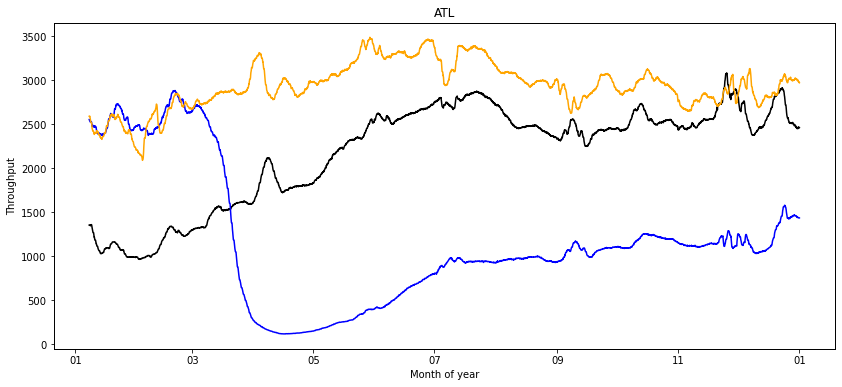

In [395]:
# Compare yearly rolling averages for ATL (window-size=168) 
overlap_timeseries(df_nona.ATL.loc['2021'].rolling(168).mean(), 
                   df_nona.ATL.loc['2020'].rolling(168).mean(), 
                   df_nona.ATL.loc['2019'].rolling(168).mean(),
                   'black', 'blue','orange', '2021', '2020', '2019', title='ATL')

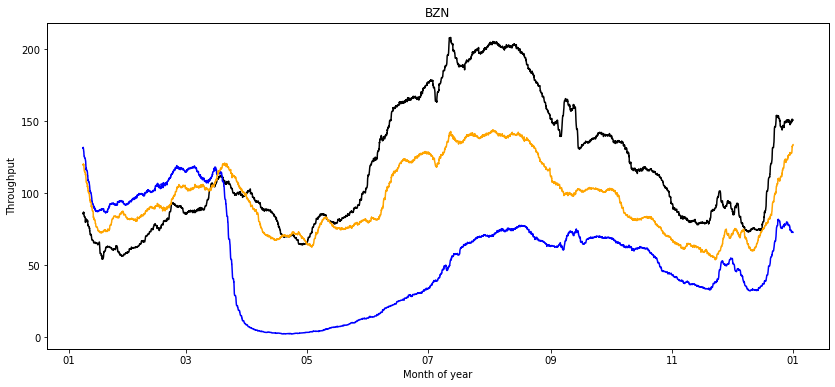

In [396]:
# Compare yearly rolling averages for BZN (window-size=168) 
overlap_timeseries(df_nona.BZN.loc['2021'].rolling(168).mean(), 
                   df_nona.BZN.loc['2020'].rolling(168).mean(), 
                   df_nona.BZN.loc['2019'].rolling(168).mean(),
                   'black', 'blue','orange', '2021', '2020', '2019', title='BZN')

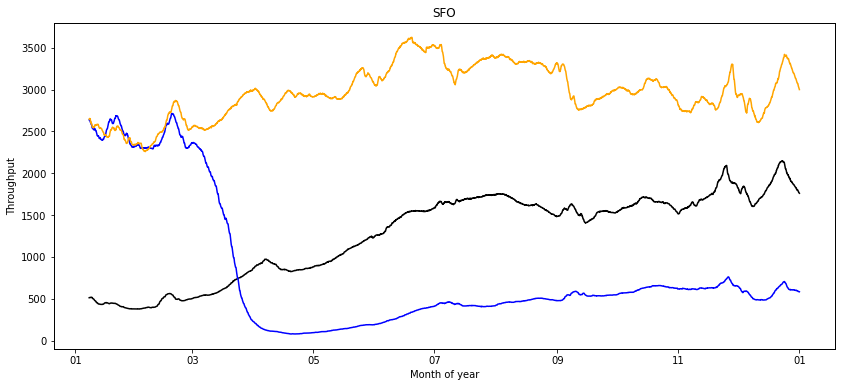

In [397]:
# Compare yearly rolling averages for SFO (window-size=168) 
overlap_timeseries(df_nona.SFO.loc['2021'].rolling(168).mean(), 
                   df_nona.SFO.loc['2020'].rolling(168).mean(), 
                   df_nona.SFO.loc['2019'].rolling(168).mean(),
                   'black', 'blue','orange', '2021', '2020', '2019', title='SFO')

# Correlation between different airports

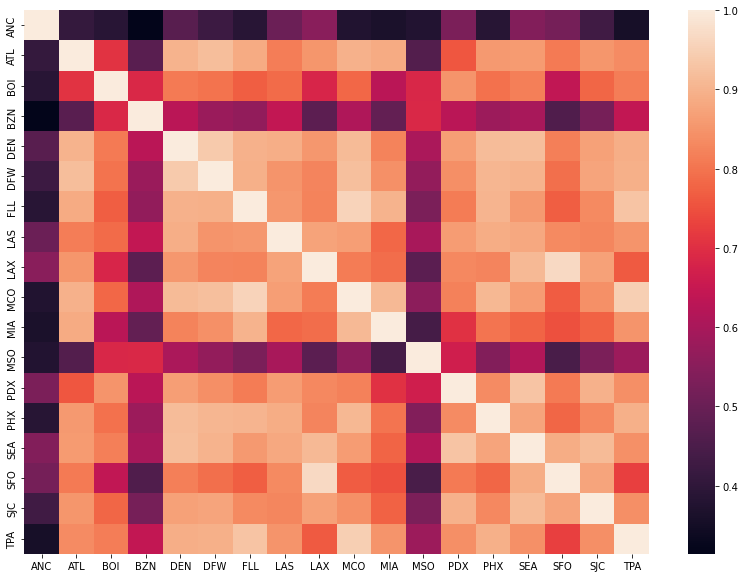

In [51]:
# Heatmap
plt.subplots(figsize=(14,10))
sns.heatmap(df_nona.corr());

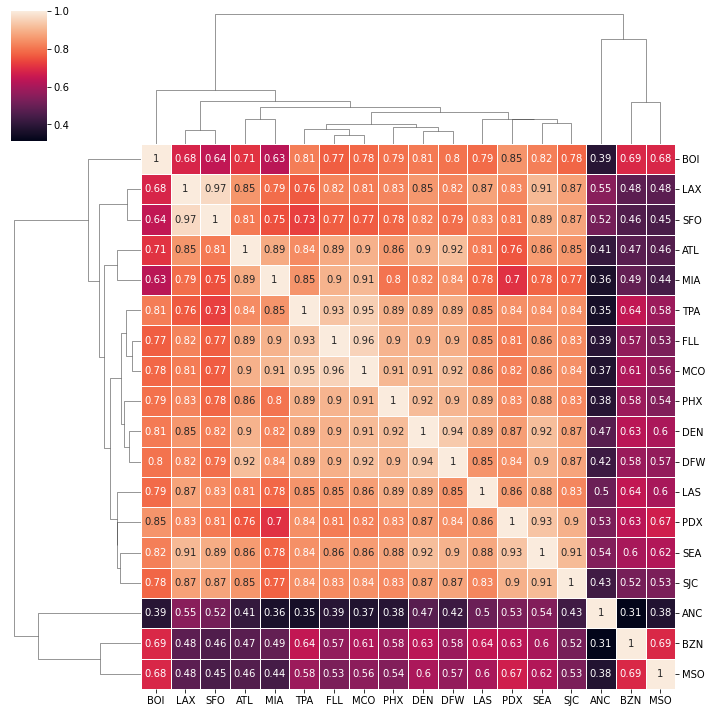

In [52]:
# Clustermap
sns.clustermap(df_nona.corr(), annot=True, linewidth=0.5);

## Autocorrelation Function

In [53]:
def plot_autocorrelation(df, lags=50):
    
    '''Plot autocorrelation plots for each timeseries in a dataframe'''
    
    fig, axs = plt.subplots(6, 3, figsize=(15, 12))
    plt.subplots_adjust(hspace=0.5)
    fig.suptitle('Autocorrelation', fontsize=18, y=0.95)

    for column, ax in zip(df.columns, axs.ravel()):
        tsaplots.plot_acf(df[column], ax=ax, lags=lags)
        ax.set_title(column)
    plt.show()

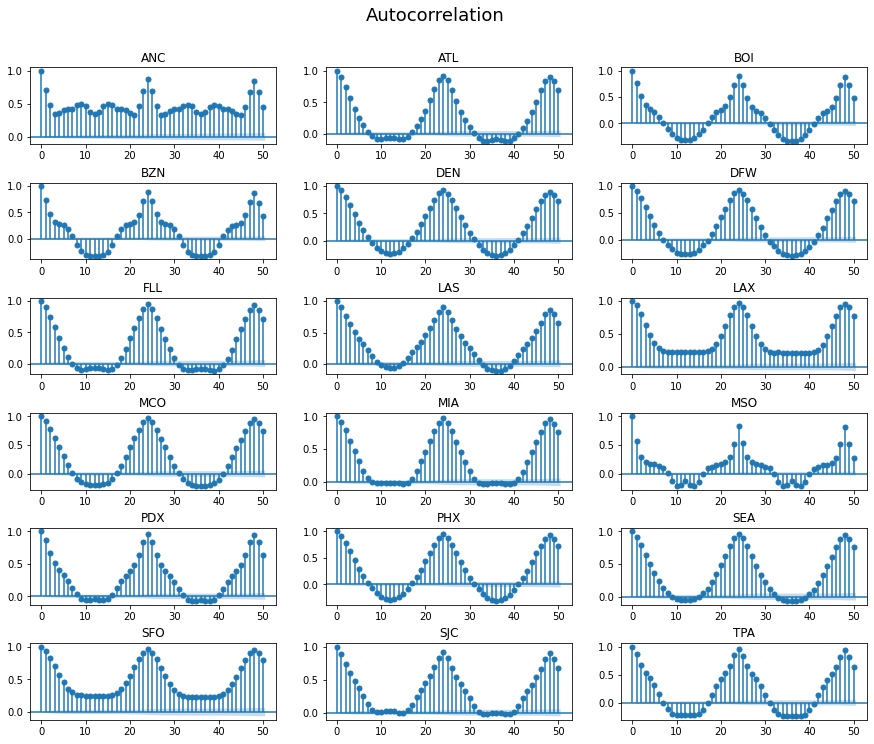

In [54]:
# Autocorrelation for each column, 50 lags
plot_autocorrelation(df_nona)

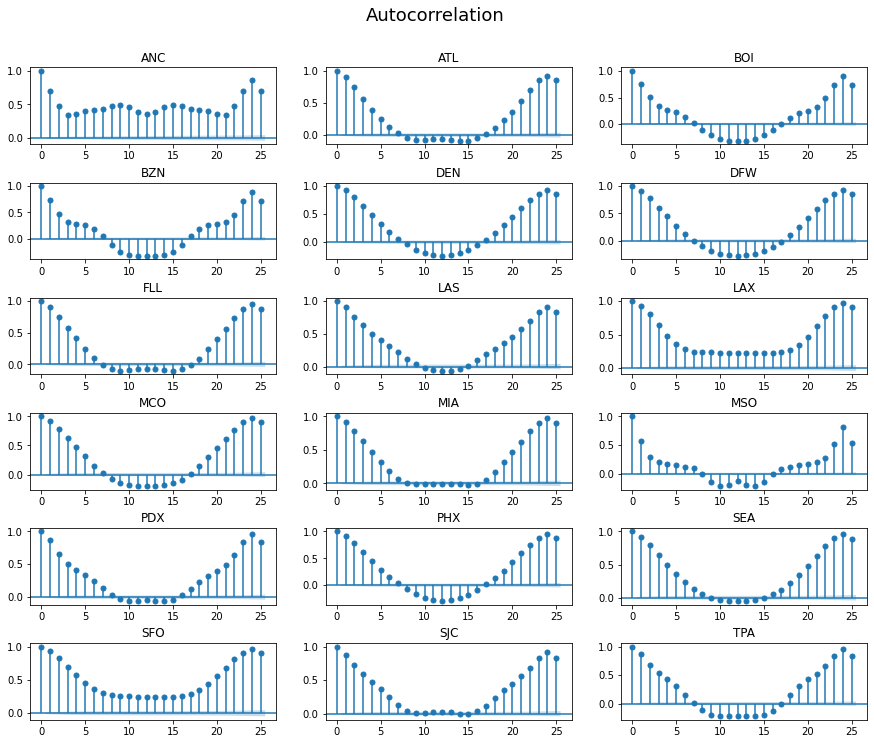

In [55]:
# Autocorrelation for each column, 20 lags
plot_autocorrelation(df_nona, 25)

## Partial autocorrelation Function

In [56]:
def plot_partial_autocorrelation(df, lags=50):
    '''Plot autocorrelation plots for each timeseries in a dataframe'''
    
    fig, axs = plt.subplots(6, 3, figsize=(15, 12))
    plt.subplots_adjust(hspace=0.5)
    fig.suptitle('Partial Autocorrelation', fontsize=18, y=0.95)

    for column, ax in zip(df.columns, axs.ravel()):
        tsaplots.plot_pacf(df[column], ax=ax, lags=lags)
        ax.set_title(column)
    plt.show()

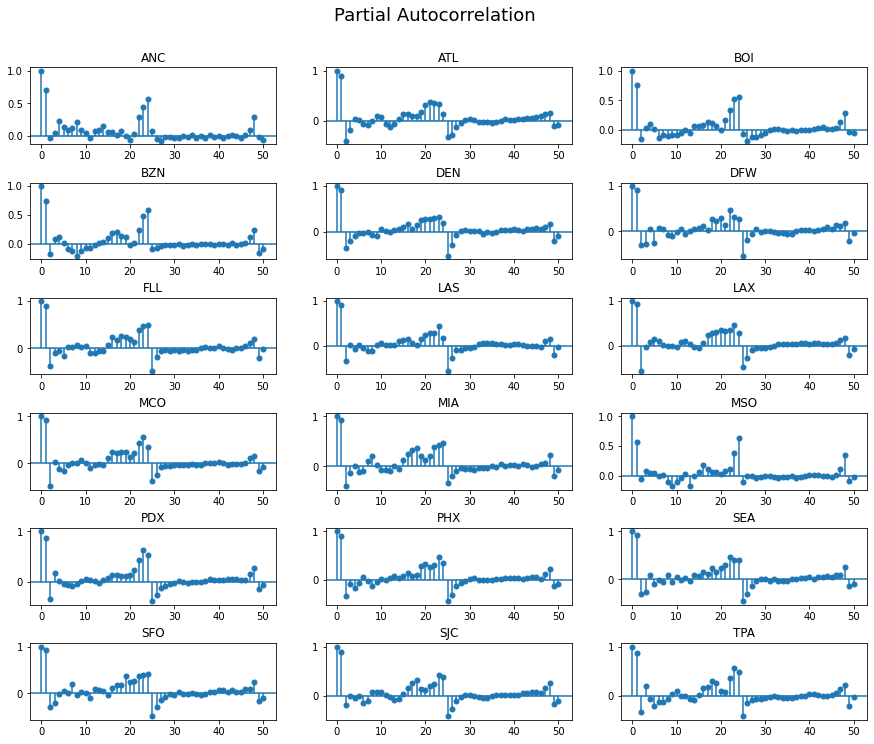

In [57]:
# Partial autocorrelation for each column, 50 lags
plot_partial_autocorrelation(df_nona)

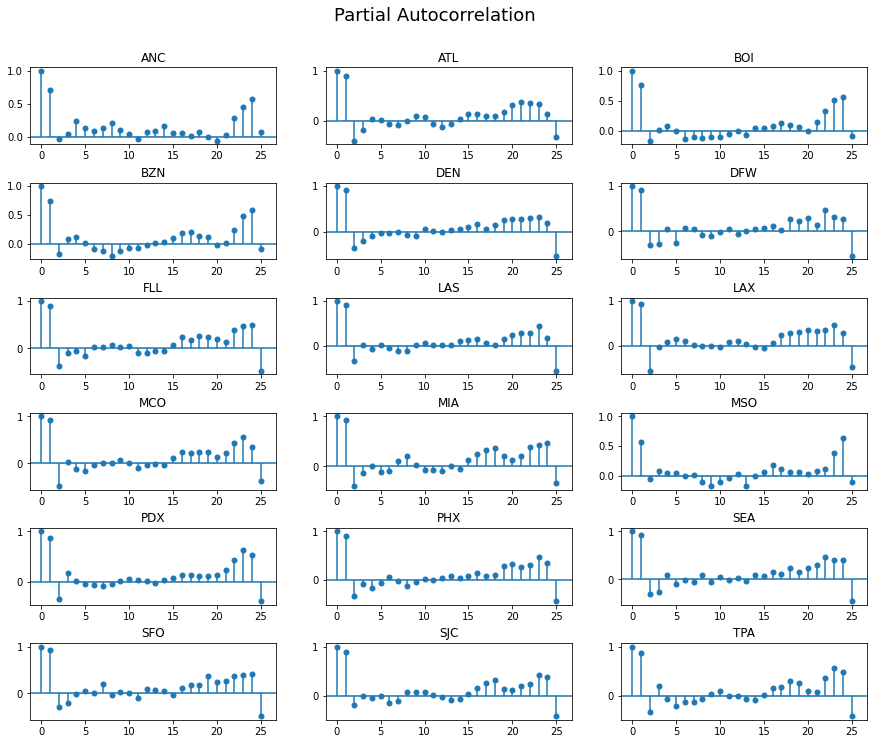

In [58]:
# Partial autocorrelation for each column, 20 lags
plot_partial_autocorrelation(df_nona, 25)

None of the series are stationary as seen from the autocorrelation and partial autocorrelation plots. 

There is strong seasionality with period of 24 hours (one day).

## AD Fuller Test

In [408]:
# Test for trend stationarity using AD fuller test
for i, series in enumerate(df_nona.columns):
    result = adfuller(df_nona[series])
    print(f'{series} - Test Statistic: {str(round(result[0],2))}, p-value: {str(round(result[1],9))}')

ANC - Test Statistic: -2.89, p-value: 0.046210258
ATL - Test Statistic: -5.32, p-value: 4.953e-06
BOI - Test Statistic: -6.14, p-value: 8.2e-08
BZN - Test Statistic: -6.61, p-value: 6e-09
DEN - Test Statistic: -6.79, p-value: 2e-09
DFW - Test Statistic: -5.96, p-value: 2.03e-07
FLL - Test Statistic: -5.66, p-value: 9.39e-07
LAS - Test Statistic: -7.98, p-value: 0.0
LAX - Test Statistic: -3.11, p-value: 0.026175059
MCO - Test Statistic: -6.14, p-value: 8.1e-08
MIA - Test Statistic: -3.88, p-value: 0.002181245
MSO - Test Statistic: -5.55, p-value: 1.635e-06
PDX - Test Statistic: -3.57, p-value: 0.00644709
PHX - Test Statistic: -5.35, p-value: 4.33e-06
SEA - Test Statistic: -3.49, p-value: 0.008339778
SFO - Test Statistic: -3.12, p-value: 0.024831495
SJC - Test Statistic: -4.91, p-value: 3.3649e-05
TPA - Test Statistic: -5.47, p-value: 2.383e-06


## Resampling

In [107]:
def resampled(df, period1, period2):
    
    '''Resample by day, week, month, quarter or year'''
    
    fig, axs = plt.subplots(6, 3, figsize=(20, 15))
    plt.subplots_adjust(hspace=0.5)
    fig.suptitle('Resampled', fontsize=18, y=0.93)

    for column, ax in zip(df.columns, axs.ravel()):
        df[column].resample(period1).mean().plot(ax = ax, color= 'pink')
        df[column].resample(period2).mean().plot(ax=ax, color='red')
        ax.set_title(column)
    plt.show()

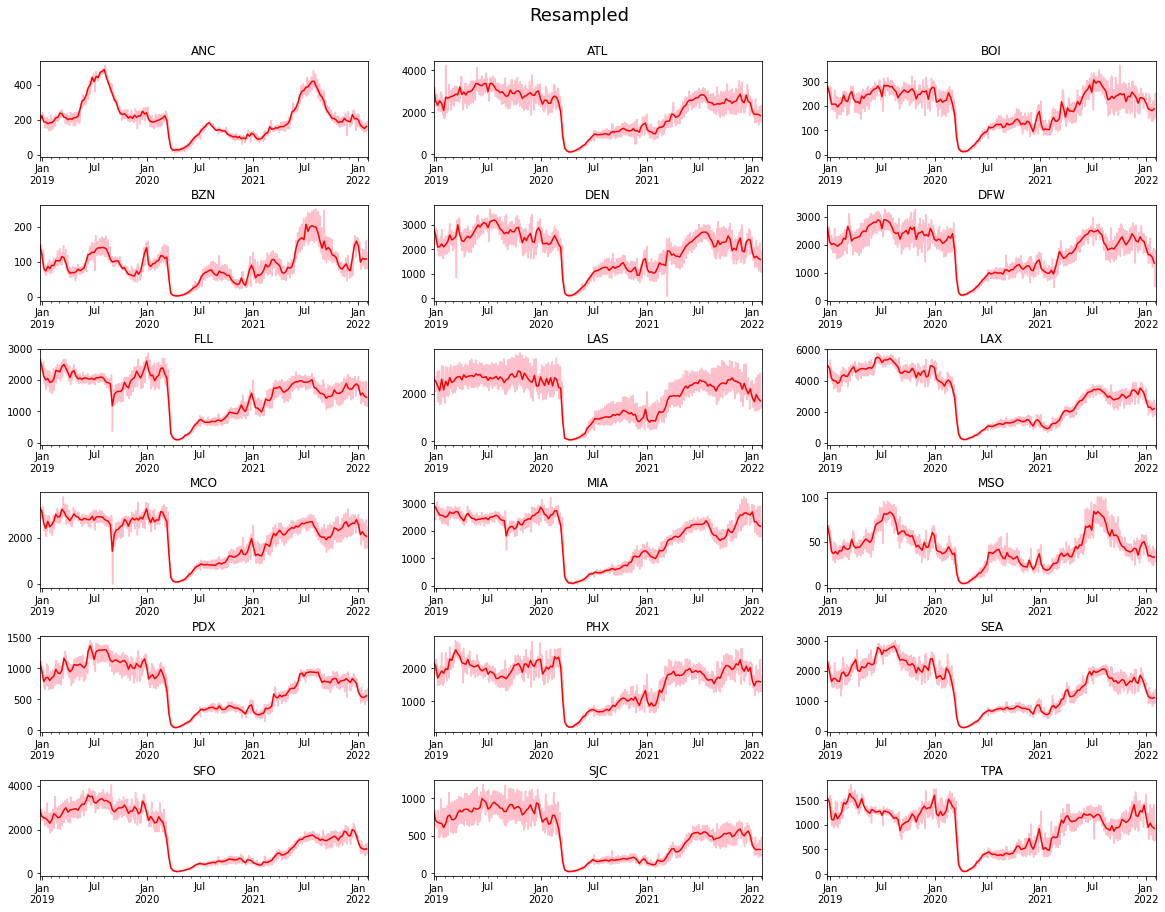

In [111]:
resampled(df_nona,'D','W')

In [62]:
def calendar_frequency(df, freq1, freq2):
    '''Plot data using calendar by calendar frequecy, day,
    week, month, quarter, and year.'''
    
    fig, axs = plt.subplots(9, 2, figsize=(13, 30))
    plt.subplots_adjust(hspace=0.5)
    fig.suptitle('By Calendar Frequency', fontsize=18, y=0.9)

    for column, ax in zip(df.columns, axs.ravel()):
        df[column].asfreq(freq1).plot(ax = ax, color= 'pink', label=freq1)
        df[column].asfreq(freq2).plot(ax=ax, color='red', label=freq2)
        ax.legend()
        ax.set_title(column)
    plt.show()

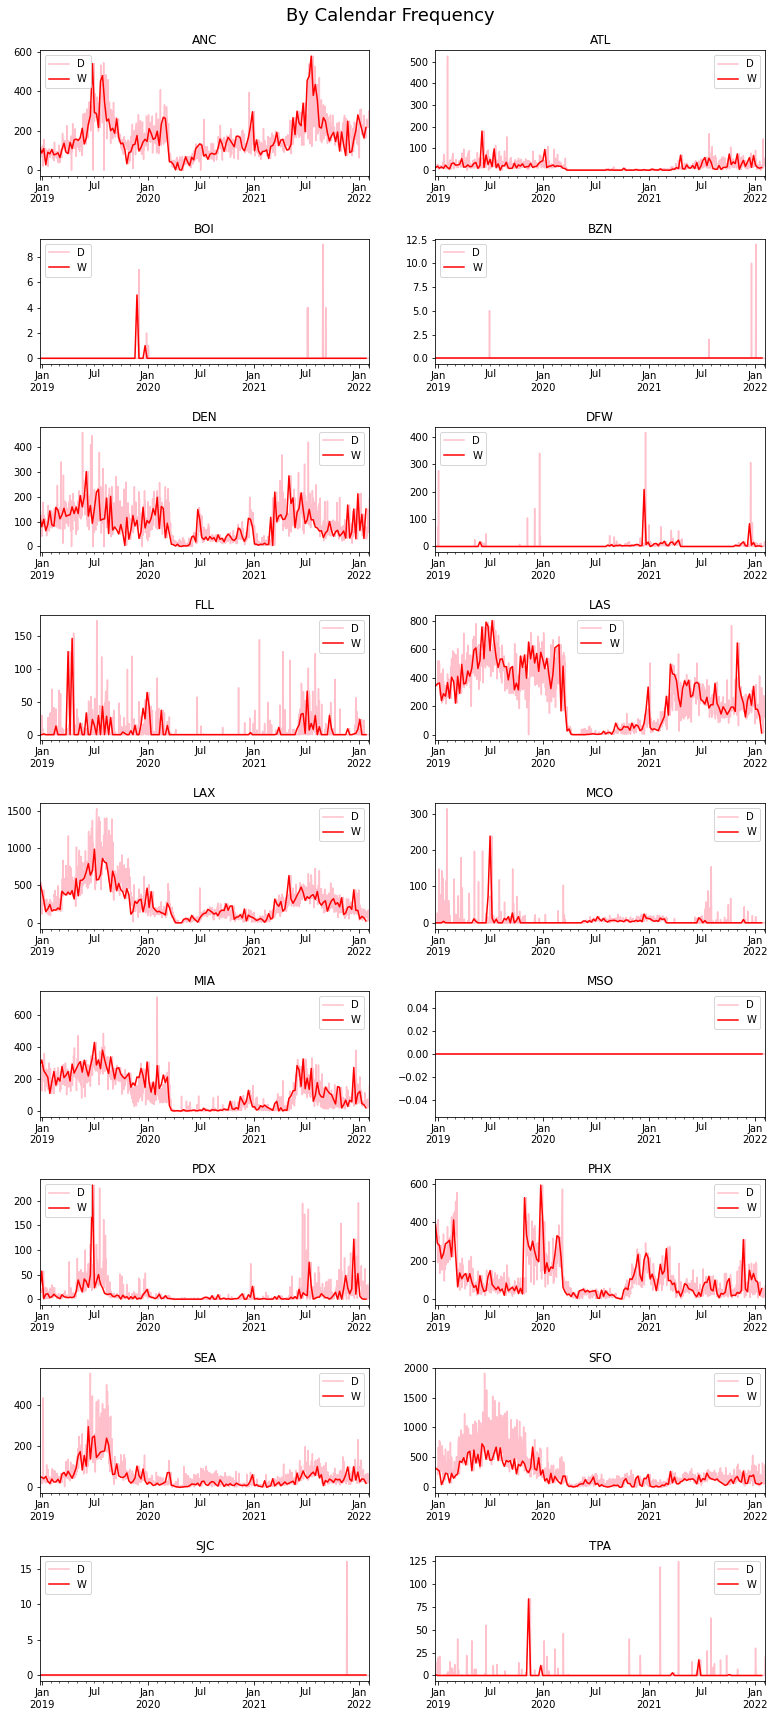

In [113]:
calendar_frequency(df_nona,'D','W')

# Decomposition

In [64]:
decomposition = sm.tsa.seasonal_decompose(df_nona['SFO'])

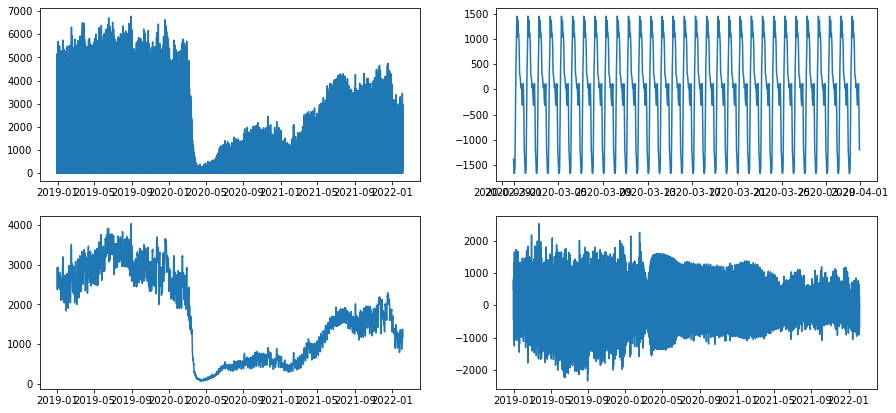

In [65]:
fig, axs = plt.subplots(2, 2, figsize=(15,7))
axs[0,0].plot(df_nona['SFO'])
axs[0,1].plot(decomposition.seasonal['2020-03'])
axs[1,0].plot(decomposition.trend)
axs[1,1].plot(decomposition.resid);

In [66]:
# Save to file
df.to_csv('../data/interim/airports.csv')